# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import hstack
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import math
import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading Data

In [33]:

data = pd.read_csv('preprocessed_data.csv')


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [34]:
X = data.drop(['project_is_approved'],axis=1)
Y = data['project_is_approved']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)


# SET 1 Bow 

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [35]:
essay_train_data = X_train['essay']
essay_test_data = X_test['essay']

#list to store all the feature names after all encodings
bow_feature_names = []

#BOW limit to 5000 features or words
bow_essay_vectorizer = CountVectorizer(min_df=10,max_features=6500)


#train_data_essay BOW fit and transform
bow_essay_vectorizer.fit(essay_train_data)

#add the features into the list
bow_feature_names.extend(bow_essay_vectorizer.get_feature_names())

bow_essay_train = bow_essay_vectorizer.transform(essay_train_data)
bow_essay_test = bow_essay_vectorizer.transform(essay_test_data)


print('shape of train/test  {} {}'.format(bow_essay_train.shape,bow_essay_test.shape))


shape of train/test  (76473, 6500) (32775, 6500)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

# Categorical Features

In [36]:
category_vectorizer = CountVectorizer()
#one hot encoding for clean categories feature
category_vectorizer.fit(X_train['clean_categories'].values)

#adding the names of the new features to the feature name list
bow_feature_names.extend(category_vectorizer.get_feature_names())

one_hot_category_train = category_vectorizer.transform(X_train['clean_categories'].values)
one_hot_category_test = category_vectorizer.transform(X_test['clean_categories'].values)

#one hot encoding for sub-categories feature
category_vectorizer.fit(X_train['clean_subcategories'].values)

#adding the names of the new features to the feature name list
bow_feature_names.extend(category_vectorizer.get_feature_names())

one_hot_subcategory_train = category_vectorizer.transform(X_train['clean_subcategories'].values)
one_hot_subcategory_test = category_vectorizer.transform(X_test['clean_subcategories'].values)

#one hot encoding for project grade category feature
category_vectorizer.fit(X_train['project_grade_category'].values)

#adding the names of the new features to the feature name list
bow_feature_names.extend(category_vectorizer.get_feature_names())

one_hot_pgradecategory_train = category_vectorizer.transform(X_train['project_grade_category'].values)
one_hot_pgradecategory_test = category_vectorizer.transform(X_test['project_grade_category'].values)

#one hot encoding for school_state feature
category_vectorizer.fit(X_train['school_state'].values)

#adding the names of the new features to the feature name list
bow_feature_names.extend(category_vectorizer.get_feature_names())

one_hot_school_state_train = category_vectorizer.transform(X_train['school_state'].values)
one_hot_school_state_test = category_vectorizer.transform(X_test['school_state'].values)

#one hot encoding for teacher prefix feature
category_vectorizer.fit(X_train['teacher_prefix'].values)

#adding the names of the new features to the feature name list
bow_feature_names.extend(category_vectorizer.get_feature_names())

one_hot_teacher_prefix_train = category_vectorizer.transform(X_train['teacher_prefix'].values)
one_hot_teacher_prefix_test = category_vectorizer.transform(X_test['teacher_prefix'].values)


# Numerical Features

In [37]:
#Normalising numerical data for better featurisation among all numerical features

normalise = Normalizer()

normalise.fit(X_train['price'].values.reshape(-1,1))

#adding the names of the new features to the feature name list
bow_feature_names.append('price')

norm_price_train = normalise.transform(X_train['price'].values.reshape(-1,1))
norm_price_test = normalise.transform(X_test['price'].values.reshape(-1,1))

normalise.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

#adding the names of the new features to the feature name list
bow_feature_names.append('teacher_number_of_previously_posted_projects')

norm_teacher_n_previously_posted_projects_train = normalise.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
norm_teacher_n_previously_posted_projects_test = normalise.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [38]:
print('Total number of features we have now is {}'.format(len(bow_feature_names)))

Total number of features we have now is 6601


# Stacking all the features (BOW)

In [39]:
#stacking all the text based and numerical features BOW

X_train_bow = hstack((bow_essay_train,one_hot_category_train,one_hot_subcategory_train,one_hot_pgradecategory_train,one_hot_school_state_train,one_hot_teacher_prefix_train,norm_price_train,norm_teacher_n_previously_posted_projects_train))
X_test_bow = hstack((bow_essay_test,one_hot_category_test,one_hot_subcategory_test,one_hot_pgradecategory_test,one_hot_school_state_test,one_hot_teacher_prefix_test,norm_price_test,norm_teacher_n_previously_posted_projects_test))
print(X_train_bow.shape,X_test_bow.shape)

(76473, 6601) (32775, 6601)


# Set 2 TFIDF 

<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [40]:
#keeping the maximum text based feature to 6500
tfidf_essay_vectorizer = TfidfVectorizer(min_df=10,max_features=6500)


#train_data_essay TFIDF fit and transform
tfidf_essay_vectorizer.fit(essay_train_data)

tfidf_essay_train = bow_essay_vectorizer.transform(essay_train_data)
tfidf_essay_test = bow_essay_vectorizer.transform(essay_test_data)


print('shape of train/test  {} {}'.format(tfidf_essay_train.shape,tfidf_essay_test.shape))

shape of train/test  (76473, 6500) (32775, 6500)


<h2>2.4 Make Data Model Ready: encoding numerical, categorical features</h2>

# Categorical Features

In [41]:
category_vectorizer = TfidfVectorizer()
#one hot encoding for clean categories feature
category_vectorizer.fit(X_train['clean_categories'].values)

one_hot_category_train = category_vectorizer.transform(X_train['clean_categories'].values)
one_hot_category_test = category_vectorizer.transform(X_test['clean_categories'].values)

#one hot encoding for sub-categories feature
category_vectorizer.fit(X_train['clean_subcategories'].values)

one_hot_subcategory_train = category_vectorizer.transform(X_train['clean_subcategories'].values)
one_hot_subcategory_test = category_vectorizer.transform(X_test['clean_subcategories'].values)

#one hot encoding for project grade category feature
category_vectorizer.fit(X_train['project_grade_category'].values)

one_hot_pgradecategory_train = category_vectorizer.transform(X_train['project_grade_category'].values)
one_hot_pgradecategory_test = category_vectorizer.transform(X_test['project_grade_category'].values)

#one hot encoding for school_state feature
category_vectorizer.fit(X_train['school_state'].values)

one_hot_school_state_train = category_vectorizer.transform(X_train['school_state'].values)
one_hot_school_state_test = category_vectorizer.transform(X_test['school_state'].values)

#one hot encoding for teacher prefix feature
category_vectorizer.fit(X_train['teacher_prefix'].values)

one_hot_teacher_prefix_train = category_vectorizer.transform(X_train['teacher_prefix'].values)
one_hot_teacher_prefix_test = category_vectorizer.transform(X_test['teacher_prefix'].values)


# Numerical Features

In [42]:
#Normalising numerical data for better featurisation among all numerical features

normalise = Normalizer()

normalise.fit(X_train['price'].values.reshape(-1,1))

norm_price_train = normalise.transform(X_train['price'].values.reshape(-1,1))
norm_price_test = normalise.transform(X_test['price'].values.reshape(-1,1))

normalise.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

norm_teacher_n_previously_posted_projects_train = normalise.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
norm_teacher_n_previously_posted_projects_test = normalise.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

# Stacking all the features (TFIDF)

In [43]:
#stacking all the text based and numerical features TFIDF

X_train_tfidf = hstack((tfidf_essay_train,one_hot_category_train,one_hot_subcategory_train,one_hot_pgradecategory_train,one_hot_school_state_train,one_hot_teacher_prefix_train,norm_price_train,norm_teacher_n_previously_posted_projects_train))
X_test_tfidf = hstack((tfidf_essay_test,one_hot_category_test,one_hot_subcategory_test,one_hot_pgradecategory_test,one_hot_school_state_test,one_hot_teacher_prefix_test,norm_price_test,norm_teacher_n_previously_posted_projects_test))
print(X_train_tfidf.shape,X_test_tfidf.shape)

(76473, 6601) (32775, 6601)


# Best Hyper-parameter using GridSearchCV

In [44]:
naive = MultinomialNB(class_prior=[0.5,0.5])

param = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000]}

#for the bow based model
NB_bow = RandomizedSearchCV(naive,param,cv=3,return_train_score=True,scoring='roc_auc')
NB_bow.fit(X_train_bow,y_train)

#for the tfidf based model
NB_tfidf = RandomizedSearchCV(naive,param,cv=3,return_train_score=True,scoring='roc_auc')
NB_tfidf.fit(X_train_tfidf,y_train)

train_auc_1 = NB_bow.cv_results_['mean_train_score']
cv_auc_1 = NB_bow.cv_results_['mean_test_score']

train_auc_2 = NB_tfidf.cv_results_['mean_train_score']
cv_auc_2 = NB_tfidf.cv_results_['mean_test_score']

print('Best value of alpha for BOW based model : {}'.format(NB_bow.best_params_['alpha']))

print('Best value of alpha for TFIDF based model : {}'.format(NB_tfidf.best_params_['alpha']))

Best value of alpha for BOW based model : 0.001
Best value of alpha for TFIDF based model : 0.001


**BOW AUC score vs Hyperparameter**

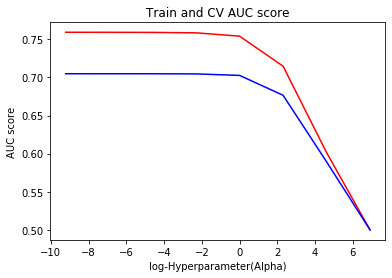

In [45]:
log_alpha = []
for alpha in param['alpha']:
    log_alpha.append(math.log(alpha))

#taking log on alpha value to plot them for better readability
plt.plot(log_alpha,train_auc_1,color='red')
plt.plot(log_alpha,cv_auc_1,color='blue')
plt.xlabel('log-Hyperparameter(Alpha)')
plt.ylabel('AUC score')
plt.title('Train and CV AUC score')
plt.show()

**TFIDF AUC score vs Hyperparameter**

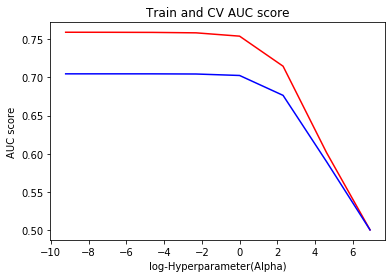

In [46]:
plt.plot(log_alpha,train_auc_2,color='red')
plt.plot(log_alpha,cv_auc_2,color='blue')
plt.xlabel('log-Hyperparameter(Alpha)')
plt.ylabel('AUC score')
plt.title('Train and CV AUC score')
plt.show()

# Observations

1. The best aplha value for both the BOW and TFIDF based model are the same i.e 0.001


2. AUC score vs hyperparameter plot is almost the same both the set of model


3. There are total 6601 features after all the encoding, including 6500 essay text features

<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# ROC curve (BOW)

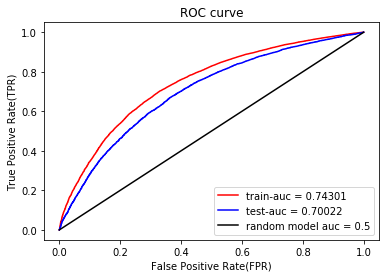

Best AUC for the model is 0.70022 


In [47]:

clf = MultinomialNB(alpha=0.001,class_prior=[0.5,0.5])
clf.fit(X_train_bow,y_train)

y_pred_train = clf.predict_proba(X_train_bow)
y_pred_test = clf.predict_proba(X_test_bow)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix

In [48]:
#custom predict function
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Confusion Matrix (BOW)

the maximum value of tpr*(1-fpr) 0.42597458856067516 for threshold 0.654


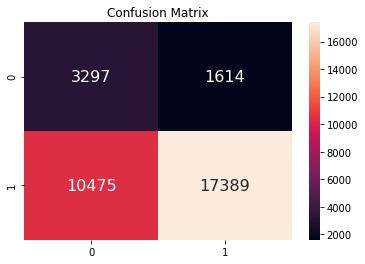

In [49]:
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

# ROC curve (TFIDF)

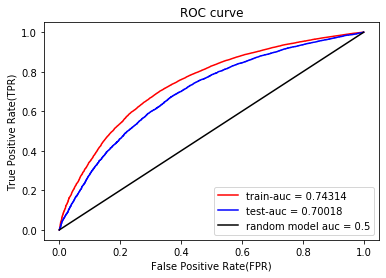

Best AUC for the model is 0.70018 


In [55]:

clf = MultinomialNB(alpha=0.001,class_prior=[0.5,0.5])
clf.fit(X_train_tfidf,y_train)

y_pred_train = clf.predict_proba(X_train_tfidf)
y_pred_test = clf.predict_proba(X_test_tfidf)

#taking the probabilit scores instead of the predicted label
#predict_proba returns probabilty scores which is in the 2nd column thus taking the second column
fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),5)
test_auc = round(auc(fpr_test,tpr_test),5)

plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

# Confusion Matrix (TFIDF)

the maximum value of tpr*(1-fpr) 0.4264094683821638 for threshold 0.641


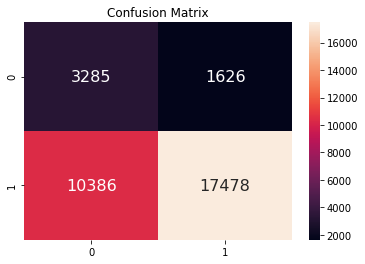

In [59]:
confusion_matrix_test = pd.DataFrame(confusion_matrix(y_test,predict(y_pred_test[:,1],threshold_test,fpr_test,tpr_test)))
sns.heatmap(confusion_matrix_test,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')
plt.show()

# Observations

1. Best AUC score, the ROC_AUC curve and the confusion matrix is almost the same in both set of models

# Top 20 features (Positive Class)

In [52]:
_sorted = clf.feature_log_prob_[1, :].argsort()[::-1]
#getting indices of the top 20 features according to their feature log probability score
feature_index = [i for i in _sorted[:20]]
top_20_feature_bow = [bow_feature_names[i] for i in feature_index]
print(top_20_feature_bow)

['students', 'school', 'my', 'learning', 'classroom', 'the', 'not', 'they', 'learn', 'help', 'price', 'many', 'nannan', 'we', 'need', 'reading', 'work', 'use', 'teacher_number_of_previously_posted_projects', 'love']


# Top 20 features (Negetive Class)

In [53]:
_sorted = clf.feature_log_prob_[0, :].argsort()[::-1]
#getting indices of the top 20 features according to their feature log probability score
feature_index = [i for i in _sorted[:20]]
top_20_feature_bow = [bow_feature_names[i] for i in feature_index]
print(top_20_feature_bow)

['students', 'school', 'learning', 'my', 'classroom', 'learn', 'not', 'they', 'help', 'the', 'price', 'nannan', 'many', 'we', 'need', 'work', 'come', 'teacher_number_of_previously_posted_projects', 'love', 'reading']


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [54]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Alpha:Hyper Parameter", " Test AUC"]

table.add_row(["BOW", "Naive Bayes", 0.001, 0.70022])
table.add_row(["TFIDF", "Naive Bayes", 0.001, 0.70018])

print(table)

+------------+-------------+-----------------------+-----------+
| Vectorizer |    Model    | Alpha:Hyper Parameter |  Test AUC |
+------------+-------------+-----------------------+-----------+
|    BOW     | Naive Bayes |         0.001         |  0.70022  |
|   TFIDF    | Naive Bayes |         0.001         |  0.70018  |
+------------+-------------+-----------------------+-----------+
